# Water Pollution Detection – Week 1 (Environmental Monitoring & Pollution Control)
This notebook builds baseline ML models to predict **Potability** (0=Not potable, 1=Potable) from water quality indicators. It includes EDA, preprocessing, model training (Logistic Regression, Random Forest), evaluation, and model export. Use the provided synthetic dataset or replace with your own (same columns).

## 1. Setup

In [12]:

# If running in a new environment, ensure packages are installed:
# !pip install pandas scikit-learn matplotlib joblib

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import joblib

BASE_DIR = "/mnt/data/Water_Pollution_Detection_Week1"
DATA_PATH = os.path.join(BASE_DIR, "data", "water_quality.csv")
print("Using data at:", DATA_PATH)


Using data at: /mnt/data/Water_Pollution_Detection_Week1\data\water_quality.csv


## 2. Load Data

In [13]:

df = pd.read_csv("water_quality.csv")
print(df.head())
print("\nShape:", df.shape)
print("\nMissing values per column:\n", df.isna().sum())


         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0  7.365660   94.196709  16431.444972     9.904737  333.031540    483.767509   
1  5.752019  161.104470  27841.526973    14.253417  395.121162    441.998556   
2  7.900541  233.618137  22249.385325     2.831430  328.279919    579.606544   
3  8.128678  191.808263  14419.542347    11.374512  446.879561    541.009977   
4  4.658758  147.954910  13072.480929     7.210407  274.567777     50.000000   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       18.233681        58.041565   3.915294           1  
1       17.694730        98.977411   5.313767           0  
2       16.687649        60.181561   5.672396           0  
3       14.367946        85.797742   4.216435           0  
4       11.378117        74.489059   5.911667           0  

Shape: (1200, 10)

Missing values per column:
 ph                 36
Hardness           36
Solids             36
Chloramines        36
Sulfate            36
C

## 3. Quick EDA

                  count          mean          std         min           25%  \
ph               1164.0      6.965372     1.183318    2.621905      6.167062   
Hardness         1164.0    195.166581    80.162053   10.000000    142.015506   
Solids           1164.0  20350.165972  7890.509721  500.000000  14849.721721   
Chloramines      1164.0      6.969998     2.939206    0.100000      4.915257   
Sulfate          1164.0    329.383755   110.841947   50.000000    252.022879   
Conductivity     1164.0    452.908116   149.837240   50.000000    354.693576   
Organic_carbon   1164.0     13.794587     4.876982    1.000000     10.519584   
Trihalomethanes  1164.0     69.174611    25.397419    5.000000     52.746426   
Turbidity        1164.0      4.018700     1.977195    0.100000      2.657106   
Potability       1200.0      0.258333     0.437901    0.000000      0.000000   

                          50%           75%           max  
ph                   6.998012      7.731775     10.814624  

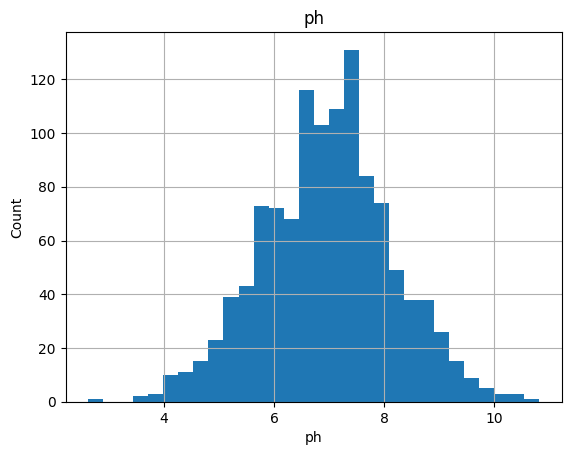

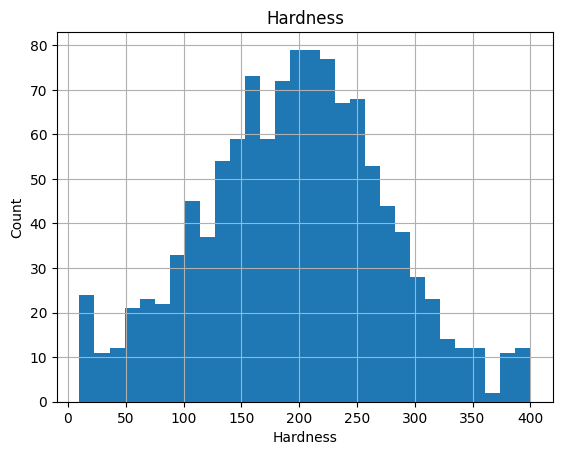

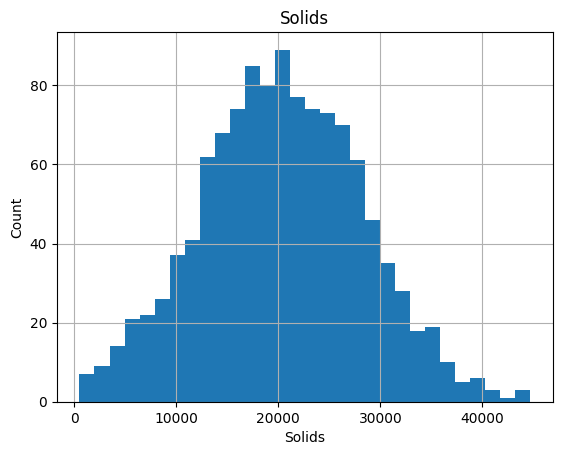

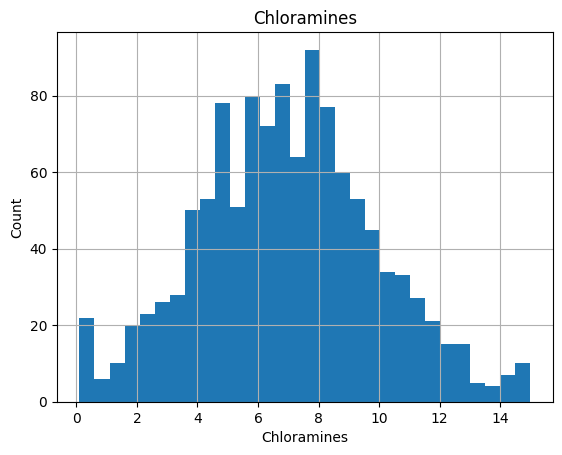

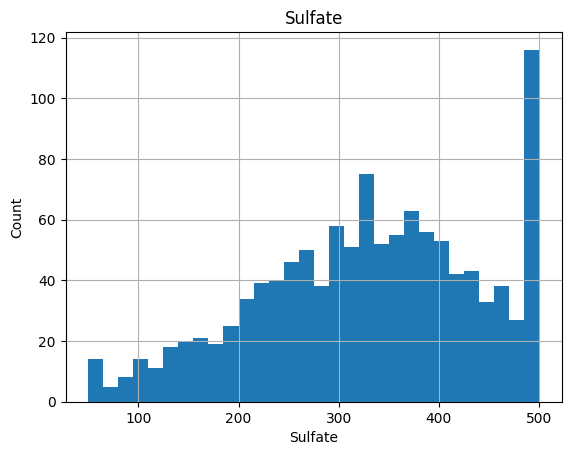

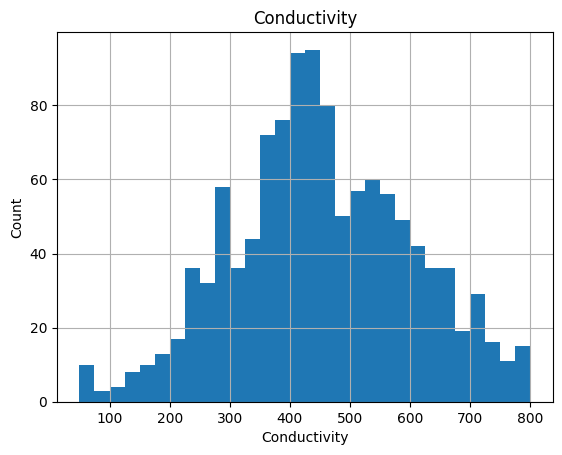

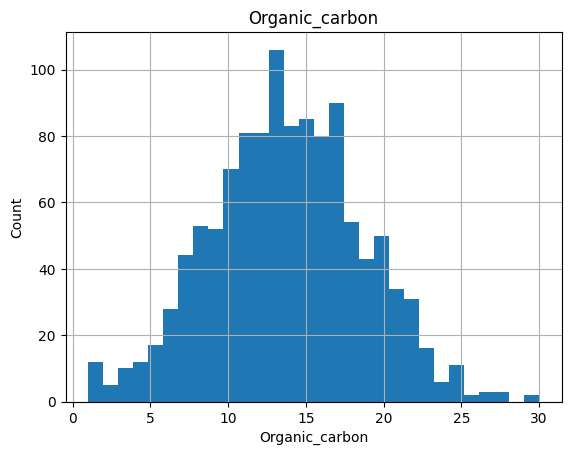

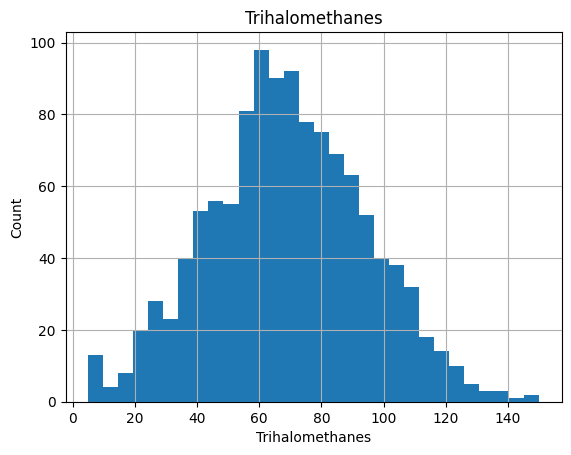

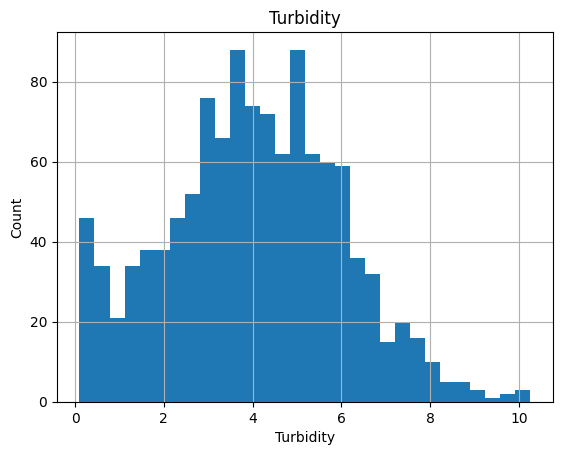

In [14]:

print(df.describe().T)

print("\nClass balance:")
print(df['Potability'].value_counts(normalize=True))

numeric_cols = [c for c in df.columns if c != 'Potability']
for col in numeric_cols:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


## 4. Train/Test Split

In [15]:

X = df.drop(columns=['Potability'])
y = df['Potability'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((960, 9), (240, 9))

## 5. Preprocessing & Baseline Models


=== LogisticRegression ===
              precision    recall  f1-score   support

           0     0.7511    0.9494    0.8387       178
           1     0.4000    0.0968    0.1558        62

    accuracy                         0.7292       240
   macro avg     0.5756    0.5231    0.4973       240
weighted avg     0.6604    0.7292    0.6623       240

Confusion Matrix:
 [[169   9]
 [ 56   6]]
ROC AUC: 0.7141


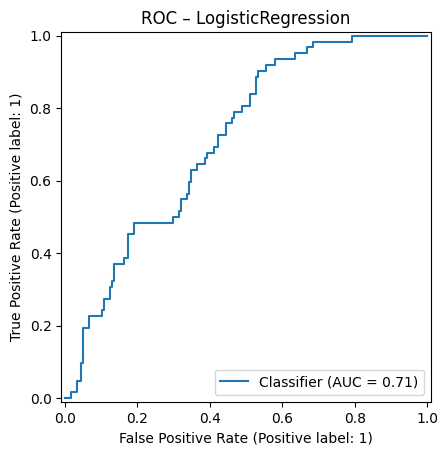


=== RandomForest ===
              precision    recall  f1-score   support

           0     0.9286    0.9494    0.9389       178
           1     0.8448    0.7903    0.8167        62

    accuracy                         0.9083       240
   macro avg     0.8867    0.8699    0.8778       240
weighted avg     0.9069    0.9083    0.9073       240

Confusion Matrix:
 [[169   9]
 [ 13  49]]
ROC AUC: 0.8979


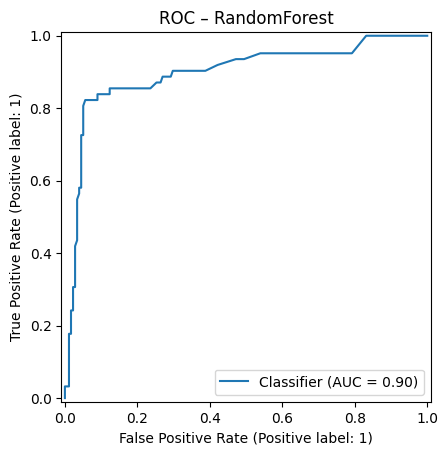

In [16]:

from sklearn.metrics import ConfusionMatrixDisplay

numeric_features = X_train.columns.tolist()

preprocess = ColumnTransformer(
    transformers=[('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_features)]
)

logreg = Pipeline(steps=[('prep', preprocess),
                        ('clf', LogisticRegression(max_iter=500))])

rf = Pipeline(steps=[('prep', preprocess),
                    ('clf', RandomForestClassifier(n_estimators=300, random_state=42))])

models = {'LogisticRegression': logreg, 'RandomForest': rf}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]
    print(f"\n=== {name} ===")
    print(classification_report(y_test, preds, digits=4))
    cm = confusion_matrix(y_test, preds)
    print("Confusion Matrix:\n", cm)
    auc = roc_auc_score(y_test, proba)
    print("ROC AUC:", round(auc, 4))

    RocCurveDisplay.from_predictions(y_test, proba)
    plt.title(f"ROC – {name}")
    plt.show()


## 6. Feature Importance (Random Forest)

ph                 0.274562
Solids             0.186627
Turbidity          0.157951
Chloramines        0.124643
Trihalomethanes    0.107440
Conductivity       0.040420
Organic_carbon     0.038229
Hardness           0.036202
Sulfate            0.033927
dtype: float64


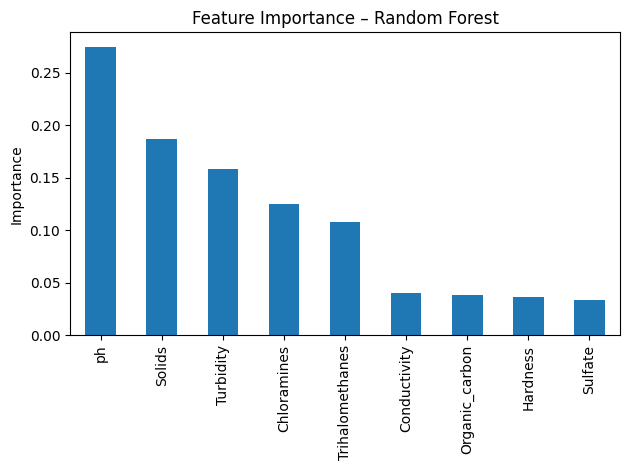

In [17]:

rf_model = models['RandomForest']
rf_est = rf_model.named_steps['clf']
importances = rf_est.feature_importances_
fi = pd.Series(importances, index=numeric_features).sort_values(ascending=False)
print(fi)

plt.figure()
fi.plot(kind='bar')
plt.title("Feature Importance – Random Forest")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


## 7. Cross-Validation (Quick Check)

In [18]:

cv_scores = cross_val_score(models['RandomForest'], X, y, cv=5, scoring='roc_auc')
print("5-fold CV ROC AUC (RF):", np.round(cv_scores, 4))
print("Mean ± Std:", round(cv_scores.mean(), 4), "±", round(cv_scores.std(), 4))


5-fold CV ROC AUC (RF): [0.883  0.8928 0.8999 0.9382 0.9392]
Mean ± Std: 0.9106 ± 0.0235


## 8. Export Best Model

In [19]:

import os

best_model = models['RandomForest']

# Save in current folder
export_path = os.path.join(os.getcwd(), "model_random_forest.joblib")

joblib.dump(best_model, export_path)
print("Model saved at:", export_path)


Model saved at: C:\Users\kundh\OneDrive\Desktop\Edunet Shell\model_random_forest.joblib


## 9. How to Replace with Your Own Dataset


- Replace `data/water_quality.csv` with your dataset having the same column names:
  `['ph','Hardness','Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity','Potability']`  
- Ensure `Potability` is 0/1. If not, map labels accordingly.
- Re-run all cells.


In [1]:
# Week 2 - Water Pollution Detection Project
# Author: Varshini Kundhu
# Description: Data Preprocessing, EDA, ML Model Training, and Evaluation


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

In [2]:
# 1. Load Dataset
df = pd.read_csv('water_quality.csv') # Replace with your dataset name
print("Dataset Shape:", df.shape)
print(df.head())

Dataset Shape: (1200, 10)
         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0  7.365660   94.196709  16431.444972     9.904737  333.031540    483.767509   
1  5.752019  161.104470  27841.526973    14.253417  395.121162    441.998556   
2  7.900541  233.618137  22249.385325     2.831430  328.279919    579.606544   
3  8.128678  191.808263  14419.542347    11.374512  446.879561    541.009977   
4  4.658758  147.954910  13072.480929     7.210407  274.567777     50.000000   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       18.233681        58.041565   3.915294           1  
1       17.694730        98.977411   5.313767           0  
2       16.687649        60.181561   5.672396           0  
3       14.367946        85.797742   4.216435           0  
4       11.378117        74.489059   5.911667           0  


In [3]:
# 2. Data Preprocessing
# Handle missing values
df.fillna(df.mean(), inplace=True)

# Separate features and target (Assume 'Potability' is target column)
X = df.drop('Potability', axis=1)
y = df['Potability']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

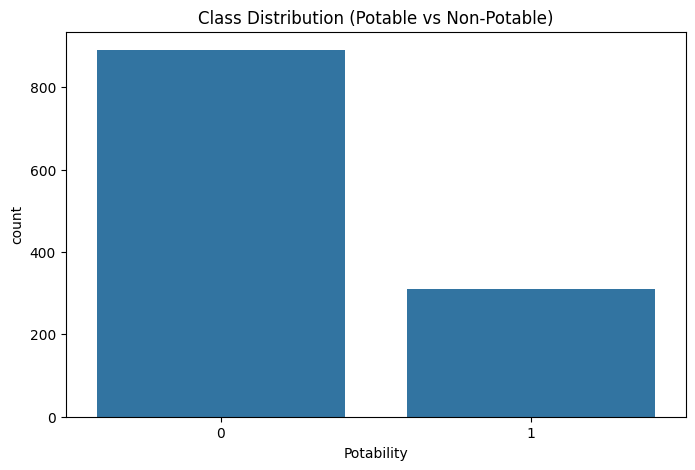

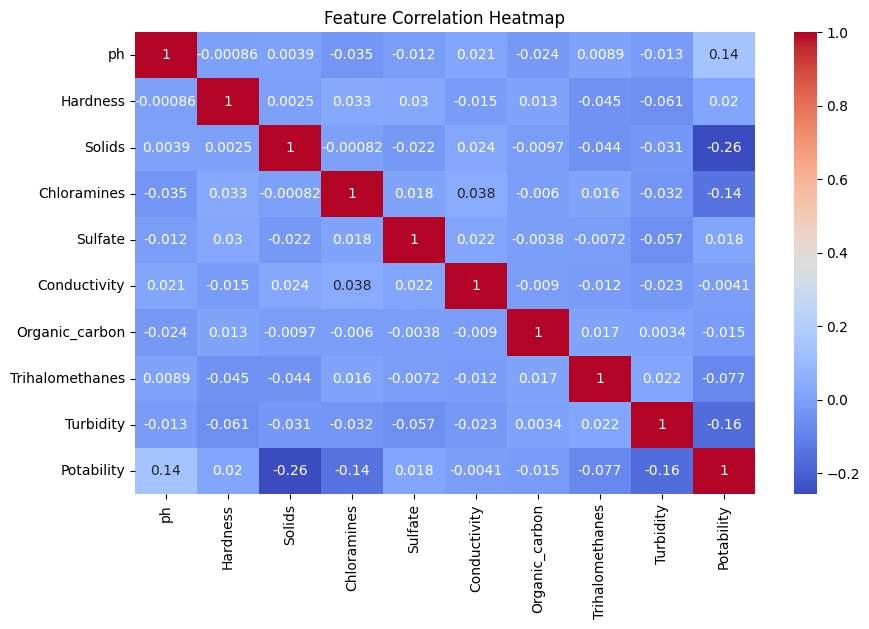

In [4]:
# 3. Exploratory Data Analysis
plt.figure(figsize=(8,5))
sns.countplot(x=y)
plt.title("Class Distribution (Potable vs Non-Potable)")
plt.show()


plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [5]:
# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [6]:
# 5. Model Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [7]:
# 6. Predictions
y_pred = model.predict(X_test)

Accuracy: 0.9375

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       182
           1       0.86      0.88      0.87        58

    accuracy                           0.94       240
   macro avg       0.91      0.92      0.92       240
weighted avg       0.94      0.94      0.94       240



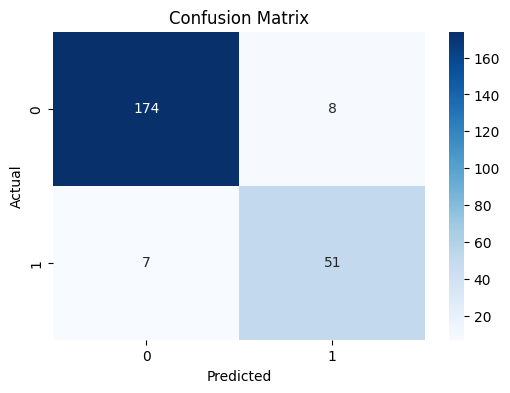

In [8]:
# 7. Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

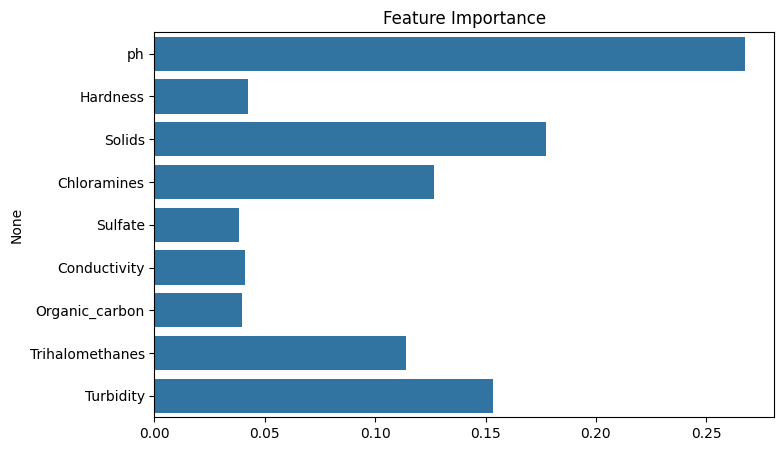

Week 2 pipeline completed successfully!


In [9]:
# 8. Feature Importance
importances = model.feature_importances_
features = X.columns
plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()


print("Week 2 pipeline completed successfully!")